In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [2]:
class EASE:
    def __init__(self, _lambda):
        self.B = None
        self._lambda = _lambda
    
    def train(self, X):
        G = X.T @ X  # G = X'X
        diag_indices = list(range(G.shape[0]))
        G[diag_indices, diag_indices] += self._lambda  # X'X + λI
        P = np.linalg.inv(G)  # P = (X'X + λI)^(-1)
        
        self.B = P / -np.diag(P)  # - P_{ij} / P_{jj} if i ≠ j
        min_dim = min(*self.B.shape)  
        self.B[range(min_dim), range(min_dim)] = 0  # 대각행렬 원소만 0으로 만들어주기 위해
    
    def forward(self, user_row):
        return user_row @ self.B


In [5]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25 #############
    seed = 42
    neg_ratio = 100 #######
    test_size = 0.2

In [6]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [7]:
# 경로 설정
data_path = './data'
saved_path = './code/saved'
output_path = './code/submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

In [8]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')

### 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [9]:
data = history_df[['profile_id', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id']).sort_values(by = ['profile_id', 'album_id']).reset_index(drop = True)
data['rating'] = 1

cfg.n_users = data.profile_id.max()+1 ##############
cfg.n_items = data.album_id.max()+1

In [12]:
data

,profile_id,album_id,rating
0,3,15,1
1,3,16,1
2,3,17,1
3,3,18,1
4,3,19,1
...,...,...,...
380542,33032,7105,1
380543,33032,8910,1
380544,33032,14662,1
380545,33032,14663,1


In [10]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (304437, 3)
검증 데이터 크기: (76110, 3)


In [11]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))  #
for (p, i, r) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/304437 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
train.shape

(33033, 25917)

In [12]:
X = train  # 학습 데이터

_lambda = 300
ease = EASE(_lambda)
ease.train(X)


In [13]:
result = ease.forward(X[:, :])
#result[X.nonzero()] = -np.inf  # 이미 어떤 한 유저가 클릭 또는 구매한 아이템 이력은 제외


In [27]:
result.min()

-0.17838588287858542

In [24]:
result

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05296504,  0.04161411, -0.00767043, ..., -0.00023127,
         0.        , -0.00023127]])

In [22]:
np.argmax(result[3])

17

In [31]:
sorted(result[3], reverse = True)

[0.5409218104996142,
 0.46602318463722847,
 0.4489749003190498,
 0.3920459982568723,
 0.3728658988954741,
 0.2391674241171719,
 0.1397879058062813,
 0.10342246881370211,
 0.07279705993137162,
 0.06471750178992695,
 0.06292080815140581,
 0.06215404330321179,
 0.06183898738381028,
 0.06008325258888757,
 0.059427054921273155,
 0.05930245136810668,
 0.05861719834494112,
 0.0584457445168445,
 0.058418657198399906,
 0.05841865719839989,
 0.05841865719839989,
 0.058418657198399886,
 0.05841865719839988,
 0.05841865719839987,
 0.05747361534237551,
 0.057165024582629204,
 0.05696909197015299,
 0.051873793936737064,
 0.05168861218482147,
 0.05043558795793662,
 0.05001858261965998,
 0.04904359237031651,
 0.04744980171935255,
 0.046866462328886076,
 0.04277539695870864,
 0.042534083577476296,
 0.04190993025017833,
 0.041448806786865584,
 0.0396805942929116,
 0.03870254662976084,
 0.03689799477414453,
 0.03689663920243768,
 0.03629337038660964,
 0.03567681838934669,
 0.03549248006212916,
 0.0341873

In [46]:
result[5].argsort()[::-1][:25]

array([ 16,  15,  38, 105, 128, 124,  74, 104,   0, 302, 291, 168, 225,
        67, 178,  76,  42, 271, 265,  65, 107, 273, 269, 270, 272])

In [49]:
profile_df.profile_id

0           3
1           5
2           7
3          12
4          16
        ...  
8306    33022
8307    33023
8308    33026
8309    33027
8310    33032
Name: profile_id, Length: 8311, dtype: int64

In [60]:
profile_id_set = set(profile_df.profile_id)
profile_id_set

{3,
 5,
 7,
 12,
 32780,
 16,
 19,
 20,
 32788,
 22,
 32789,
 24,
 32791,
 26,
 27,
 32792,
 30,
 31,
 32798,
 33,
 32801,
 35,
 32807,
 32815,
 32817,
 55,
 56,
 59,
 32829,
 62,
 63,
 32831,
 66,
 68,
 74,
 77,
 32846,
 80,
 32849,
 32852,
 32854,
 89,
 32857,
 32858,
 32861,
 94,
 32862,
 96,
 32864,
 32867,
 101,
 102,
 103,
 32869,
 109,
 110,
 32877,
 32878,
 32882,
 115,
 116,
 118,
 121,
 122,
 124,
 32892,
 127,
 32896,
 129,
 130,
 32901,
 32903,
 136,
 137,
 32904,
 139,
 32908,
 32909,
 144,
 150,
 32918,
 152,
 32922,
 156,
 32927,
 32928,
 165,
 32934,
 32935,
 32936,
 170,
 172,
 32943,
 176,
 32944,
 32945,
 179,
 32946,
 181,
 182,
 32949,
 32950,
 187,
 32957,
 192,
 193,
 32962,
 195,
 32963,
 32965,
 198,
 201,
 32973,
 32974,
 207,
 32976,
 209,
 32978,
 211,
 32979,
 214,
 32982,
 32984,
 220,
 32994,
 32995,
 228,
 229,
 230,
 32998,
 33000,
 233,
 240,
 33011,
 33015,
 248,
 33016,
 251,
 33019,
 33022,
 255,
 33023,
 258,
 33026,
 260,
 261,
 33027,
 264,
 3303

In [64]:
train.shape

(33033, 25917)

In [107]:
item_dict = dict()
for i in range(10):
    if i in profile_id_set:
        s = list(result[i].argsort()[::-1][:25])
        item_dict[i] = s

In [109]:
item_dict = dict()
for i in range(train.shape[0]):
    if i in profile_id_set:
        s = list(result[i].argsort()[::-1][:25])
        item_dict[i] = s

In [110]:
print(item_dict)

{3: [17, 16, 15, 19, 18, 38, 224, 229, 241, 225, 228, 33, 186, 20, 25, 24, 136, 981, 27, 28, 23, 30, 29, 21, 26], 5: [16, 15, 38, 105, 128, 124, 74, 104, 0, 302, 291, 168, 225, 67, 178, 76, 42, 271, 265, 65, 107, 273, 269, 270, 272], 7: [255, 0, 256, 207, 329, 347, 2027, 2268, 364, 36, 208, 16, 241, 1602, 1880, 2054, 2071, 2458, 383, 190, 2125, 2059, 3, 2660, 254], 12: [3663, 356, 357, 3664, 2174, 737, 3665, 353, 2630, 354, 740, 416, 4047, 2629, 606, 355, 4790, 9452, 4791, 1469, 230, 1880, 329, 419, 684], 16: [124, 190, 125, 127, 2029, 1402, 52, 241, 50, 65, 339, 126, 329, 2491, 380, 338, 1888, 2472, 347, 2272, 55, 423, 2469, 425, 1884], 19: [5990, 403, 999, 996, 2735, 404, 1998, 2668, 1999, 5991, 612, 2567, 2669, 183, 0, 5992, 1880, 2792, 16, 1330, 71, 2736, 73, 2641, 1329], 20: [476, 426, 442, 478, 488, 437, 436, 471, 490, 441, 503, 452, 491, 329, 458, 2045, 241, 508, 2491, 475, 438, 505, 459, 502, 501], 22: [16, 128, 15, 67, 254, 172, 19, 129, 36, 782, 17, 684, 227, 18, 703, 264, 84

In [111]:
result_dict = dict()
result_dict['profile_id'] = item_dict

In [112]:
result_dict

{'profile_id': {3: [17,
   16,
   15,
   19,
   18,
   38,
   224,
   229,
   241,
   225,
   228,
   33,
   186,
   20,
   25,
   24,
   136,
   981,
   27,
   28,
   23,
   30,
   29,
   21,
   26],
  5: [16,
   15,
   38,
   105,
   128,
   124,
   74,
   104,
   0,
   302,
   291,
   168,
   225,
   67,
   178,
   76,
   42,
   271,
   265,
   65,
   107,
   273,
   269,
   270,
   272],
  7: [255,
   0,
   256,
   207,
   329,
   347,
   2027,
   2268,
   364,
   36,
   208,
   16,
   241,
   1602,
   1880,
   2054,
   2071,
   2458,
   383,
   190,
   2125,
   2059,
   3,
   2660,
   254],
  12: [3663,
   356,
   357,
   3664,
   2174,
   737,
   3665,
   353,
   2630,
   354,
   740,
   416,
   4047,
   2629,
   606,
   355,
   4790,
   9452,
   4791,
   1469,
   230,
   1880,
   329,
   419,
   684],
  16: [124,
   190,
   125,
   127,
   2029,
   1402,
   52,
   241,
   50,
   65,
   339,
   126,
   329,
   2491,
   380,
   338,
   1888,
   2472,
   347,
   2272,
   55,
   423

In [113]:
pred_df_ease = pd.DataFrame(result_dict)
pred_df_result = pred_df_ease.reset_index()
pred_df_result.columns = ['profile_id', 'predicted_list']

In [115]:
pred_df_result.to_csv('ease_result.csv', index = False)

In [21]:
# 아이템 특징 정보 추출 
meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
item_features = meta_df[['genre_mid']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])

album_id 749의 genre_mid 정보 : 1


In [69]:
item_features

{'genre_mid': {749: 1,
  750: 1,
  2131: 1,
  2625: 1,
  2594: 1,
  2637: 1,
  2636: 1,
  748: 1,
  1381: 1,
  1380: 1,
  746: 1,
  745: 1,
  744: 1,
  628: 1,
  627: 1,
  626: 1,
  631: 1,
  630: 1,
  629: 1,
  6744: 1,
  7037: 1,
  668: 1,
  632: 1,
  817: 1,
  816: 1,
  815: 1,
  26077: 12,
  26078: 12,
  26079: 12,
  21481: 12,
  26080: 12,
  13771: 12,
  26081: 12,
  19720: 12,
  26082: 12,
  20690: 12,
  26083: 12,
  20703: 12,
  26084: 27,
  26068: 27,
  9826: 27,
  25095: 27,
  3881: 1,
  10487: 1,
  9460: 1,
  9459: 1,
  9458: 1,
  10513: 1,
  6733: 1,
  6732: 1,
  6731: 1,
  10512: 1,
  9808: 1,
  10515: 1,
  10514: 1,
  25328: 27,
  26085: 27,
  7856: 4,
  4503: 1,
  9814: 1,
  9809: 1,
  26086: 27,
  25322: 27,
  25311: 27,
  25317: 27,
  25318: 27,
  25319: 27,
  26087: 27,
  25312: 27,
  26088: 27,
  25326: 27,
  10605: 4,
  7884: 4,
  10325: 4,
  2088: 1,
  2087: 1,
  2086: 1,
  1981: 1,
  1455: 1,
  3886: 1,
  4506: 1,
  4505: 1,
  4504: 1,
  25321: 27,
  25314: 27,
  2

In [13]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_continuous_feats = 1 

In [31]:
class NeuMF(nn.Module):
    def __init__(self, cfg):
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_continuous_feats, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        user_embedding_mf = self.user_embedding_mf(user_indices)
        print(user_embedding_mf.shape)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        print(item_embedding_mf.shape)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        print(mf_output.shape)
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_embedding_mlp = self.genre_embeddig(feats[1])
        print(genre_embedding_mlp.shape)
        print(feats[0].shape)
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, feats[0].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

In [32]:
model = NeuMF(cfg)

In [18]:
user_indices = np.arange(cfg.n_users)
np.random.RandomState(cfg.epochs).shuffle(user_indices)
batch_num = int(len(user_indices) / cfg.batch_size) + 1
bar = tqdm(range(batch_num), leave=False)

  0%|          | 0/130 [00:00<?, ?it/s]

In [33]:
 for step, batch_idx in enumerate(bar):
        
        if step ==1:
            break
        user_ids, item_ids, feat0, feat1, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids)
        item_ids = torch.LongTensor(item_ids)
        feat0 = torch.FloatTensor(feat0)
        feat1 = torch.LongTensor(feat1)
        labels = torch.FloatTensor(labels)
        labels = labels.view(-1, 1)
        
        output = model.forward(user_ids, item_ids, [feat0, feat1])
        
        if step ==1:
            break

torch.Size([197213, 256])
torch.Size([197213, 256])
torch.Size([197213, 256])
torch.Size([197213, 14])


In [34]:
output.shape  # 해당 배치만큼 각 앨범 인덱스의 확률값 도출

torch.Size([197213])

In [35]:
output

tensor([0.0003, 0.0007, 0.0006,  ..., 0.0005, 0.0002, 0.0003],
       grad_fn=<SqueezeBackward1>)

In [30]:
torch.mul(torch.Tensor([[1],[2],[3]]),(torch.Tensor([[1],[2],[3]])))

tensor([[1.],
        [4.],
        [9.]])

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [20]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = []
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 추출 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['age'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(item_features['genre_mid'][item_id])
        UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [23]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [21]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_labels = []
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        labels = UIdataset[user_id][3]
        user_ids = np.full(len(item_ids), user_id)
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [21]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.LongTensor(feat1).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [22]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))]) 
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [23]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    for user_id in query_user_ids:
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [15]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 25
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [26]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [27]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(best_scores).pth'))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  22994.523440  0.164926  0.123564  0.001630  0.154586


  0%|          | 0/130 [00:00<?, ?it/s]

01  9984.540040  0.217146  0.174013  0.008677  0.206363


  0%|          | 0/130 [00:00<?, ?it/s]

02  8173.796390  0.366468  0.275312  0.058583  0.343679


  0%|          | 0/130 [00:00<?, ?it/s]

03  6028.666020  0.454342  0.336304  0.150119  0.424832


  0%|          | 0/130 [00:00<?, ?it/s]

04  4172.378420  0.478199  0.349060  0.222345  0.445915


  0%|          | 0/130 [00:00<?, ?it/s]

05  2727.645260  0.489309  0.355896  0.287097  0.455956


  0%|          | 0/130 [00:00<?, ?it/s]

06  1805.808470  0.498579  0.359368  0.333743  0.463776


  0%|          | 0/130 [00:00<?, ?it/s]

07  1218.287110  0.499672  0.361139  0.337605  0.465038


  0%|          | 0/130 [00:00<?, ?it/s]

08  838.307920  0.499664  0.360341  0.342094  0.464833


  0%|          | 0/130 [00:00<?, ?it/s]

09  572.293580  0.498445  0.359396  0.345204  0.463682


  0%|          | 0/130 [00:00<?, ?it/s]

10  390.889830  0.500437  0.360767  0.359599  0.465519


  0%|          | 0/130 [00:00<?, ?it/s]

11  274.851170  0.498653  0.359902  0.353781  0.463965


  0%|          | 0/130 [00:00<?, ?it/s]

12  193.380050  0.498407  0.359773  0.356263  0.463748


  0%|          | 0/130 [00:00<?, ?it/s]

13  138.260640  0.498718  0.359634  0.354834  0.463947


  0%|          | 0/130 [00:00<?, ?it/s]

14  101.739270  0.499001  0.359769  0.356915  0.464193


  0%|          | 0/130 [00:00<?, ?it/s]

15  77.930600  0.498442  0.359795  0.358194  0.463780


  0%|          | 0/130 [00:00<?, ?it/s]

16  61.643610  0.497572  0.359140  0.356113  0.462964


  0%|          | 0/130 [00:00<?, ?it/s]

17  50.221570  0.497556  0.359211  0.358972  0.462970


  0%|          | 0/130 [00:00<?, ?it/s]

18  41.716410  0.497487  0.358969  0.356514  0.462857


  0%|          | 0/130 [00:00<?, ?it/s]

19  35.054590  0.497249  0.358989  0.356013  0.462684


  0%|          | 0/130 [00:00<?, ?it/s]

20  29.770020  0.497460  0.358986  0.357016  0.462841


  0%|          | 0/130 [00:00<?, ?it/s]

21  25.483410  0.497505  0.358827  0.355862  0.462835


  0%|          | 0/130 [00:00<?, ?it/s]

22  21.977840  0.497580  0.358806  0.356013  0.462886


  0%|          | 0/130 [00:00<?, ?it/s]

23  19.062020  0.497672  0.358557  0.355636  0.462893


  0%|          | 0/130 [00:00<?, ?it/s]

24  16.651720  0.497592  0.358429  0.355561  0.462801


  0%|          | 0/130 [00:00<?, ?it/s]

25  14.591610  0.498112  0.358451  0.354307  0.463197


### 학습 과정 시각화

In [28]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

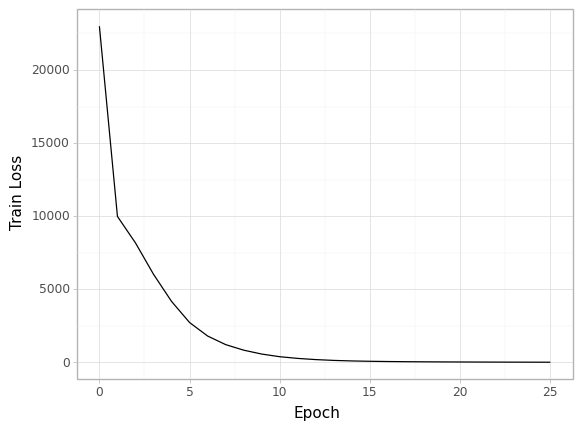

<ggplot: (8784468712578)>

In [29]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [30]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

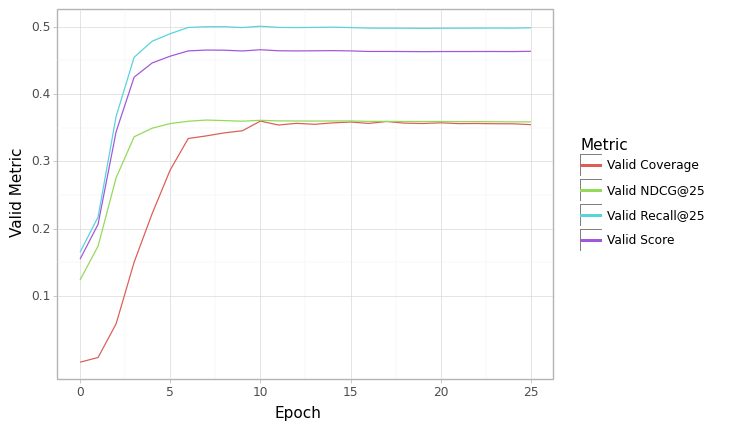

<ggplot: (8784470020590)>

In [31]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [32]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(best_scores).pth')))

<All keys matched successfully>

In [33]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

### 저장

In [34]:
submission.to_csv(os.path.join(output_path, 'submission.csv'), index = False)